In [263]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


data = fetch_california_housing(as_frame=True)
X = data.data
y = data.target


print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [264]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [265]:
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [266]:
def evaluate_linear_regression(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    results = pd.DataFrame({
        'RMSE': [
            np.sqrt(mean_squared_error(y_train, y_train_pred)),
            np.sqrt(mean_squared_error(y_test, y_test_pred))
        ],
        'R2': [
            r2_score(y_train, y_train_pred),
            r2_score(y_test, y_test_pred)
        ]
    }, index=['Train', 'Test'])

    return results



In [267]:
X.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

In [268]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

results = evaluate_linear_regression(X_train, X_test, y_train, y_test)
results

,RMSE,R2
Train,0.719676,0.612551
Test,0.745581,0.575788


In [269]:
data = fetch_california_housing(as_frame=True)
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

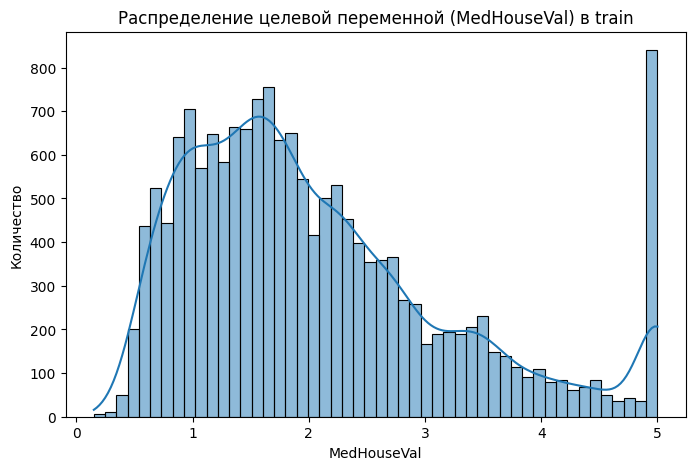

In [270]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(y_train, bins=50, kde=True)
plt.title('Распределение целевой переменной (MedHouseVal) в train')
plt.xlabel('MedHouseVal')
plt.ylabel('Количество')
plt.show()

Видно резкий всплеск на уровне 5, что можно считать выбросами (аномалиями)

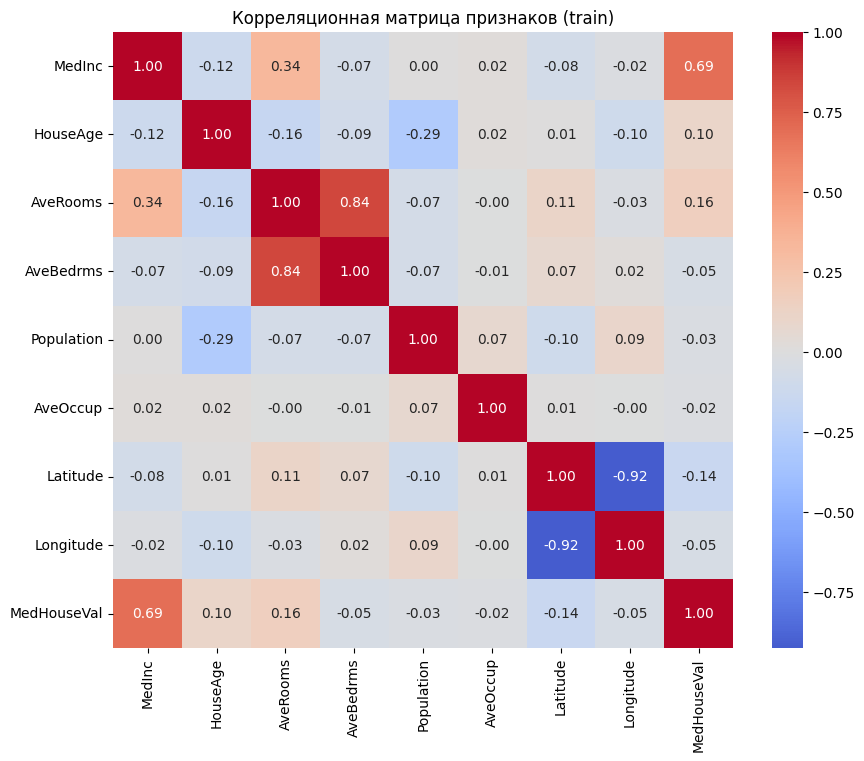

In [271]:
train_df = X_train.copy()
train_df['MedHouseVal'] = y_train.values
corr_matrix = train_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Корреляционная матрица признаков (train)')
plt.show()

AveBedrms можно удалить, так как он сильно дублирует AveRooms.
MedInc имеет заметную положительную связь с целевой переменной.
Population, AveOccup имеют слабую связь

In [272]:
X_train= X_train.drop(columns=['AveBedrms', 'Population', 'AveOccup'])
X_test= X_test.drop(columns=['AveBedrms', 'Population', 'AveOccup'])

In [273]:
results = evaluate_linear_regression(X_train, X_test, y_train, y_test)
results

,RMSE,R2
Train,0.732652,0.598453
Test,0.740656,0.581374


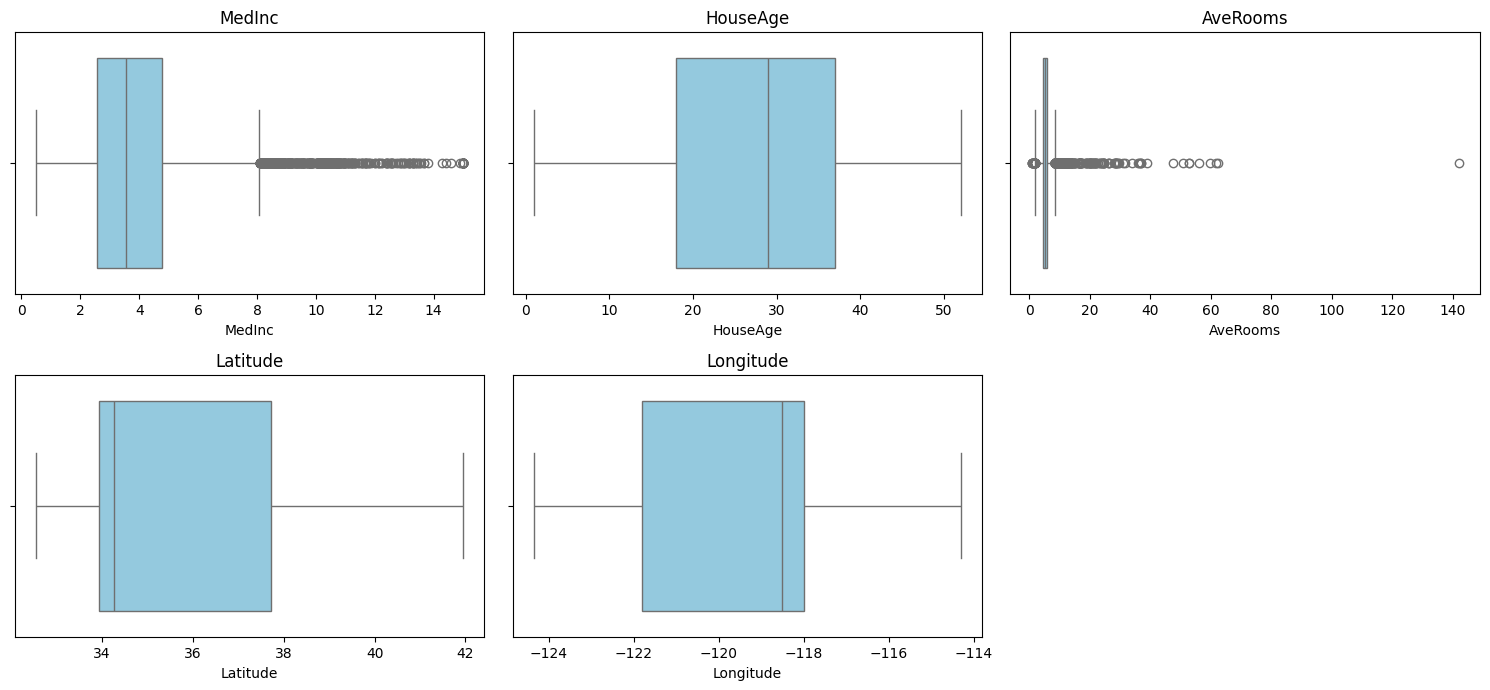

In [274]:
plt.figure(figsize=(15,10))
for i, col in enumerate(X_train.columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=X_train[col], color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()

In [275]:
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

train_df = X_train.copy()
train_df['MedHouseVal'] = y_train.values

columns_with_outliers = ['MedInc','AveRooms']
train_df_clean = remove_outliers_iqr(train_df, columns_with_outliers)

X_train = train_df_clean.drop(columns=['MedHouseVal'])
y_train = train_df_clean['MedHouseVal']

test_df = X_test.copy()
test_df['MedHouseVal'] = y_test.values

test_df_clean = remove_outliers_iqr(test_df, columns_with_outliers)

X_test = test_df_clean.drop(columns=['MedHouseVal'])
y_test = test_df_clean['MedHouseVal']

In [276]:
results = evaluate_linear_regression(X_train, X_test, y_train, y_test)
results

,RMSE,R2
Train,0.716436,0.548086
Test,0.729772,0.513868


In [277]:
X_mod = X_train.copy()
y_mod = np.log1p(y_train)

X_mod['MedInc'] = np.log1p(X_mod['MedInc'])

X_modt = X_test.copy()

X_modt['MedInc'] = np.log1p(X_modt['MedInc'])

In [278]:
model = LinearRegression()
model.fit(X_mod, y_mod)

y_train_pred = model.predict(X_mod)
y_test_pred = model.predict(X_modt)

results = pd.DataFrame({
    'RMSE': [
        np.sqrt(mean_squared_error(y_train, np.expm1(y_train_pred))),
        np.sqrt(mean_squared_error(y_test, np.expm1(y_test_pred)))
    ],
    'R2': [
        r2_score(y_train, np.expm1(y_train_pred)),
        r2_score(y_test, np.expm1(y_test_pred))
    ]
}, index=['Train', 'Test'])

results

,RMSE,R2
Train,0.717676,0.546520
Test,0.724048,0.521464


Были удалены признаки со слабой взаимосвязью с целевой переменной и дублированием других признаков, были убраны аномалии, а также добавлено преобразование логарифмирования для целевой переменной и признака.
Удалось добиться улучшения метрик.
Модели справились в полной мере для улучшения предсказаний необходимы дополнительные исследования и улучшения самой модели